Import Packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import randint
import seaborn as sns
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import train_test_split,RandomizedSearchCV,KFold,learning_curve
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
import xgboost as xgb
from sklearn.metrics import r2_score,root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import shap

Load dataset

In [ ]:
data=pd.read_csv('/content/Main_database.csv')
data=data.drop(['Source'],axis=1)
data.sort_values(by=['Filename','T(K)'],inplace=True)
data=data.reset_index(drop=True)
data.head()

,Filename,T(K),Pressure(bar),adsorption (mmol/g),hoa (kcal/mol),Metal node,Metal%,UC_volume,Density,ASA,AVAf
0,DB0-m12_o10_bcu,298.0,0.10,0.471610,5.524992,Ni,5.26,1993.43,0.722574,441.926,0.22994
1,DB0-m12_o10_bcu,298.0,1.00,4.848368,6.268464,Ni,5.26,1993.43,0.722574,441.926,0.22994
2,DB0-m12_o10_bcu,313.0,0.40,1.290993,5.104519,Ni,5.26,1993.43,0.722574,441.926,0.22994
3,DB0-m12_o10_bcu,313.0,16.00,18.526928,7.295877,Ni,5.26,1993.43,0.722574,441.926,0.22994
4,DB0-m12_o10_bcu,338.0,0.26,0.422267,5.201924,Ni,5.26,1993.43,0.722574,441.926,0.22994


Check for missing and zero values

In [ ]:
print(data.isna().sum())
print((data == 0).sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1677534 entries, 0 to 1677533
Data columns (total 11 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   Filename             1677534 non-null  object 
 1   T(K)                 1677534 non-null  float64
 2   Pressure(bar)        1677534 non-null  float64
 3   adsorption (mmol/g)  1677534 non-null  float64
 4   hoa (kcal/mol)       1676509 non-null  float64
 5   Metal node           1654284 non-null  object 
 6   Metal%               1677534 non-null  float64
 7   UC_volume            1673880 non-null  float64
 8   Density              1673880 non-null  float64
 9   ASA                  1673880 non-null  float64
 10  AVAf                 1673880 non-null  float64
dtypes: float64(9), object(2)
memory usage: 140.8+ MB


,0
Filename,0
T(K),0
Pressure(bar),0
adsorption (mmol/g),1025
hoa (kcal/mol),0
Metal node,0
Metal%,23250
UC_volume,0
Density,0
ASA,45696


Remove missing and zero values

In [ ]:
data.dropna(inplace=True)
data = data[~(data == 0).any(axis=1)]

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1610904 entries, 0 to 1677527
Data columns (total 11 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   Filename             1610904 non-null  object 
 1   T(K)                 1610904 non-null  float64
 2   Pressure(bar)        1610904 non-null  float64
 3   adsorption (mmol/g)  1610904 non-null  float64
 4   hoa (kcal/mol)       1610904 non-null  float64
 5   Metal node           1610904 non-null  object 
 6   Metal%               1610904 non-null  float64
 7   UC_volume            1610904 non-null  float64
 8   Density              1610904 non-null  float64
 9   ASA                  1610904 non-null  float64
 10  AVAf                 1610904 non-null  float64
dtypes: float64(9), object(2)
memory usage: 147.5+ MB


In [ ]:
data['Metal node'].value_counts()

,count
Metal node,
Zn,722915
Cu,519913
Fe,225882
V,81846
Co,25483
Cd,14805
Al,7092
Ni,5680
Mn,3096


Function creation

In [ ]:
def datasplit(dataframe,coltorem,stratify):
  X=dataframe.drop(coltorem,axis=1)
  y=dataframe['Adsorption']
  X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=stratify)
  return (X_train,X_test,y_train,y_test)

In [ ]:
def featureimp(model,dataframe):
  featureimp=model.feature_importances_
  featurename=dataframe.columns
  importance_df = pd.DataFrame({
      'Feature': featurename,
      'Importance': featureimp
  }).sort_values(by='Importance', ascending=False)

  ax = sns.barplot(data=importance_df, x='Importance', y='Feature')
  ax.bar_label(ax.containers[0], fmt='%.3f', padding=3)
  plt.show()

def viz(ytest,ypred):
  predf=pd.DataFrame({'Actual':ytest,'Predicted':ypred})
  sns.scatterplot(data=predf,x='Actual',y='Predicted',marker='+',label='Predicted')
  sns.scatterplot(data=predf,x='Actual',y='Actual',marker='o',label='Actual')
  plt.legend()
  plt.show()

In [ ]:
def plot_learning_curves(model, mdlnm, X, y, cv=5,scoring2="r2"):

    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=cv, n_jobs=-1, scoring=scoring2,
        train_sizes=[50,100,250,750,1500,2250,3000,4000], shuffle=True, random_state=42
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    plt.plot(train_sizes, train_scores_mean, label='Training score',marker='o')
    plt.plot(train_sizes, val_scores_mean, label='Validation score',marker='o')
    plt.xlabel('Number of samples in training set')
    plt.ylabel('R²')
    plt.title(f'Learning Curve for {mdlnm}')
    plt.legend()
    plt.grid(False)
    plt.tight_layout()
    plt.show()
    return train_scores_mean, val_scores_mean


In [ ]:
param_dist_rf = {
    'n_estimators': randint(5,500),
    'max_depth': randint(1,50),
    'max_features': randint(2,8),
    'min_samples_split':randint(2,20,2),
    'min_samples_leaf':randint(2,20,2)
}

param_dist_lg = {
    'n_estimators': randint(1,1000),
    'max_depth': randint(1,14),
    'learning_rate':[0.01,0.05,0.1,0.5,0.9],
    'subsample':[0.1,0.3,0.5,0.8,1]

}

param_dist_xg = {
    'n_estimators': randint(1,1000),
    'max_depth': randint(1,16),
    'learning_rate':[0.01,0.05,0.1,0.5,0.9],
    'subsample':[0.2,0.3,0.5,0.8,1],
    'gamma':[0, 0.1, 0.5, 1],

}

rfmodel=RandomForestRegressor(random_state=22)
xgmodel=xgb.XGBRegressor(objective='reg:pseudohubererror',random_state=22)
lgmodel = LGBMRegressor(objective='regression_l1',random_state=22,verbosity=-1)

In [ ]:
def modeltrain(model,param,X_train,y_train):
  kf=KFold(n_splits=5, shuffle=True, random_state=32)
  random_search = RandomizedSearchCV(
      estimator=model,
      param_distributions=param,
      n_iter=50,
      cv=kf,
      scoring='r2',
      verbose=2,
      random_state=42,
      n_jobs=-1
  )

  random_search.fit(X_train, y_train)
  bestscore=random_search.best_score_
  bestmodel=random_search.best_estimator_
  return (bestmodel,bestscore)

def modelresult(bestmodel,X_train,y_train,X_test,y_test):
  bestmodel.fit(X_train,y_train)
  ytrainpred=bestmodel.predict(X_train)
  modelpred=bestmodel.predict(X_test)
  trainscore=bestmodel.score(X_train,y_train)
  testscore=bestmodel.score(X_test,y_test)
  rmsetrain=root_mean_squared_error(y_train,ytrainpred)
  rmse=root_mean_squared_error(y_test,modelpred)
  maetrain=mean_absolute_error(y_train,ytrainpred)
  mae=mean_absolute_error(y_test,modelpred)
  mape=mean_absolute_percentage_error(y_test,modelpred)
  return (trainscore,testscore,rmsetrain,rmse,maetrain,mae,mape,ytrainpred,modelpred)

Analysis for learning curve

In [ ]:
X=data.drop(['Filename','adsorption (mmol/g)','Metal node'],axis=1)
y=data['adsorption (mmol/g)']

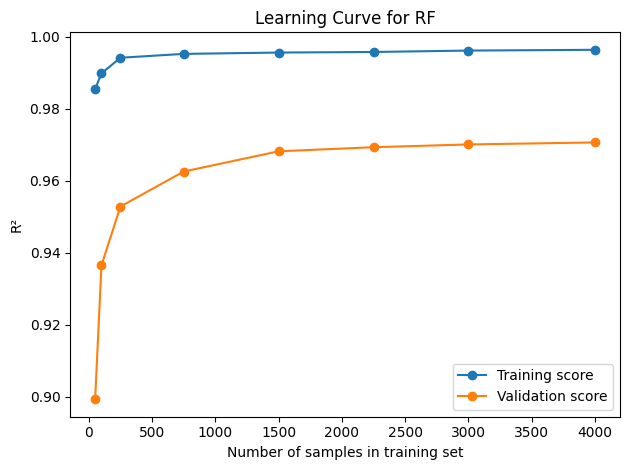

In [ ]:
train_score,val_score=plot_learning_curves(RandomForestRegressor(random_state=42),"RF",X,y)

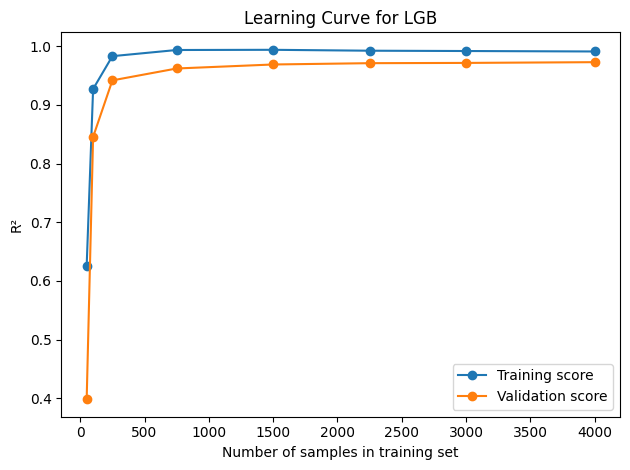

In [ ]:
train_score2,val_score2=plot_learning_curves(LGBMRegressor(random_state=42),"LGB",X,y)


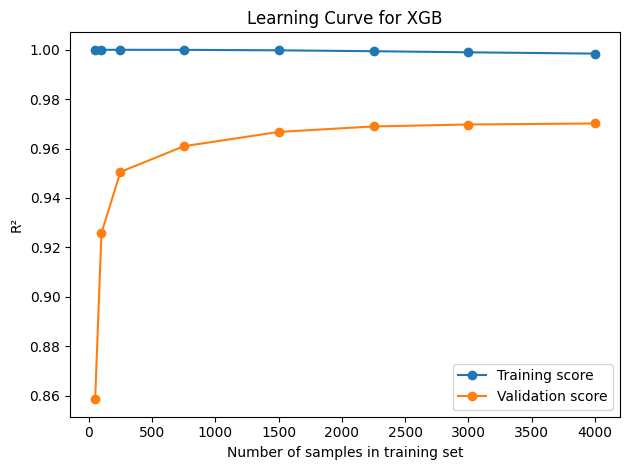

In [ ]:
train_score3,val_score3=plot_learning_curves(xgb.XGBRegressor(random_state=42),"XGB",X,y)

Dataset creation

In [ ]:
df=data.sample(3000,random_state=42)
df=df.reset_index(drop=True)
column_to_move = 'adsorption (mmol/g)'
new_columns = [col for col in df.columns if col != column_to_move] + [column_to_move]
df = df[new_columns]
df = df.rename(columns={'T(K)':'T','Pressure(bar)': 'P', 'hoa (kcal/mol)':'HOA','Metal%': 'M%','UC_volume':'UCV','Density':'D','adsorption (mmol/g)':'Adsorption','AVAf':'AVAF'})

In [ ]:
df.info()

In [ ]:
df['Metal node'].value_counts()

,count
Metal node,
Zn,1385
Cu,935
Fe,409
V,144
Co,51
Cd,28
Al,16
Ni,13
Mn,8


EDA for the dataset

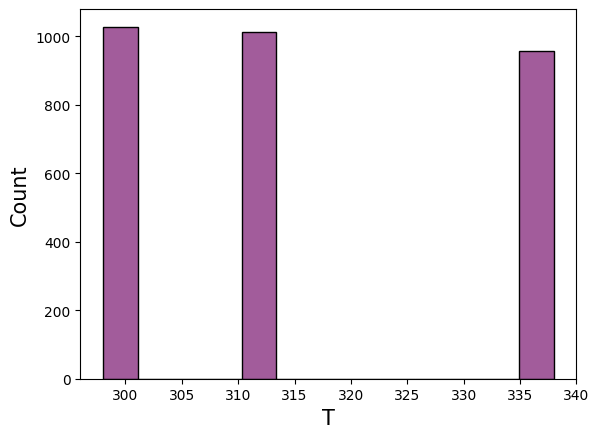

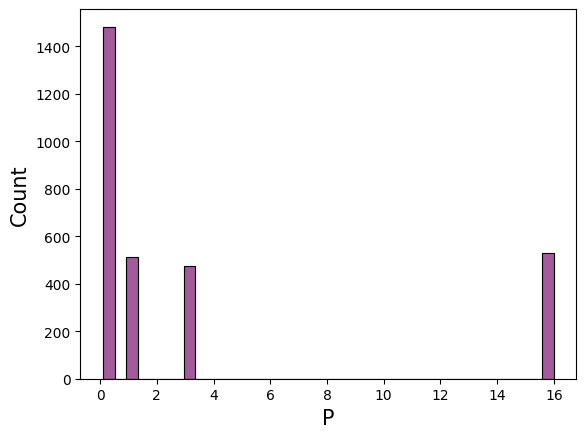

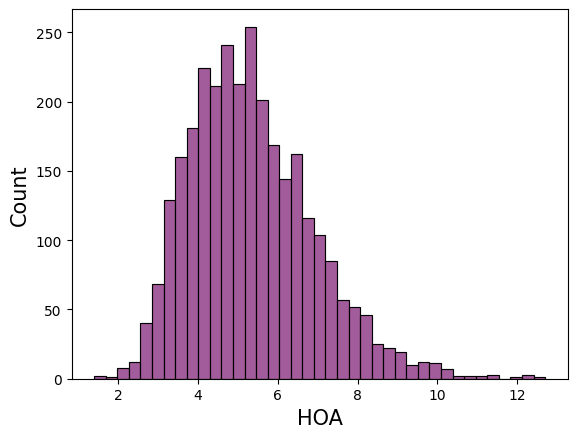

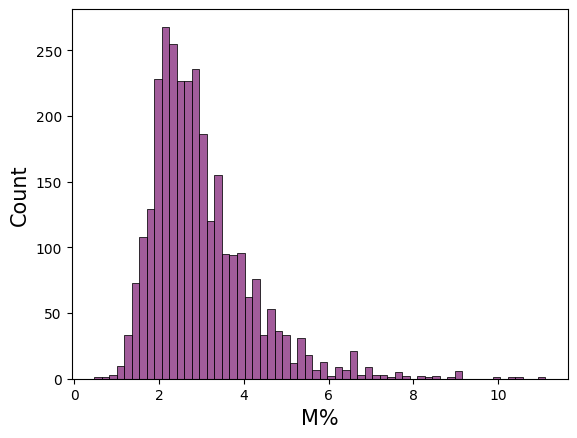

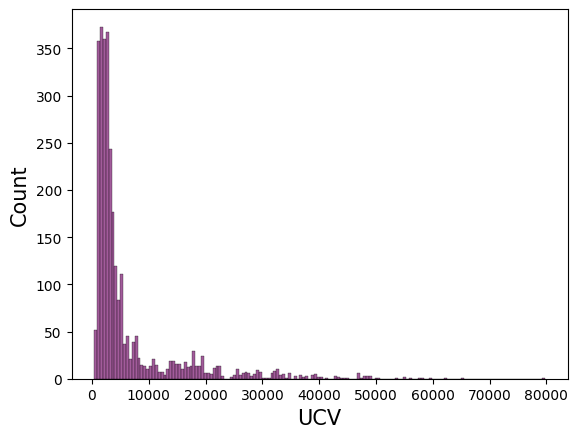

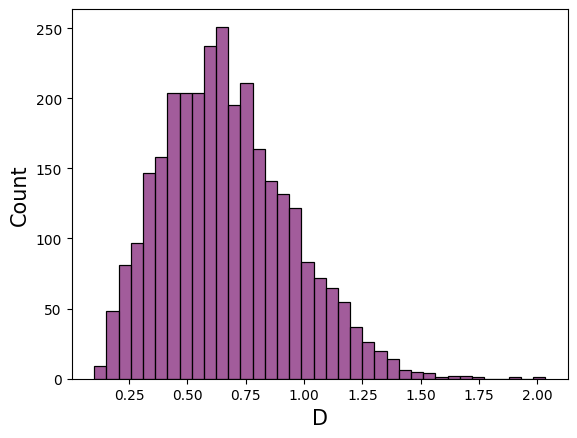

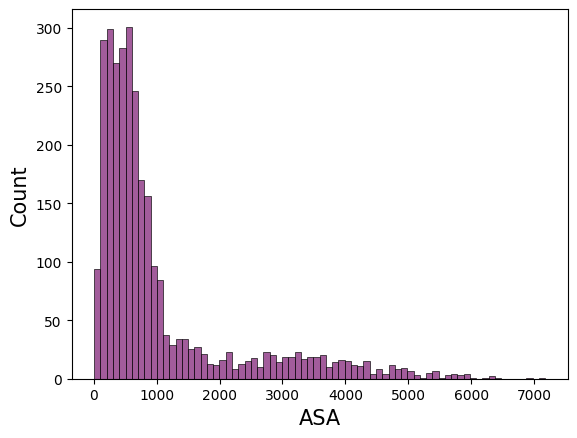

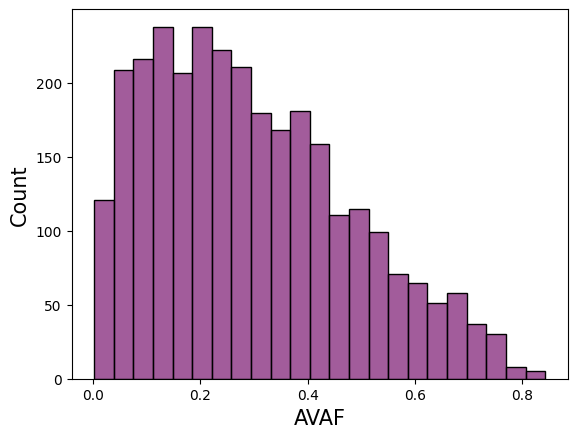

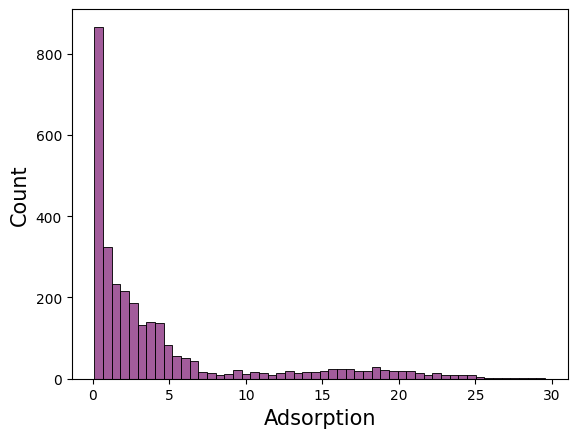

In [ ]:
numdf=df.select_dtypes(include='number')
for feat in numdf:
  sns.histplot(df[feat],color='#83267A')
  plt.xlabel(f"{feat}",fontsize=15)
  plt.ylabel("Count",fontsize=15)
  plt.show()

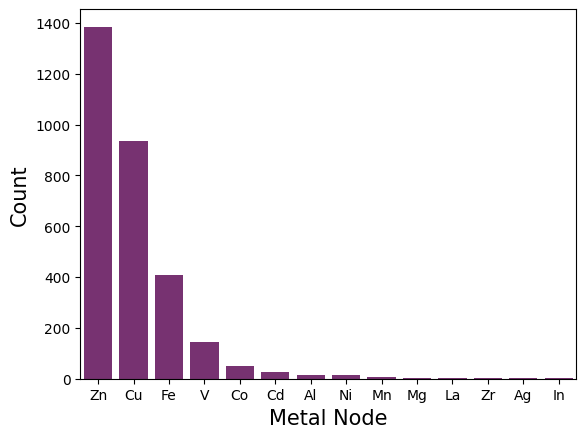

In [ ]:
order = df['Metal node'].value_counts().index
sns.countplot(x='Metal node', data=df, order=order,color='#83267A')
plt.xlabel('Metal Node',fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.show()

Correlation plot

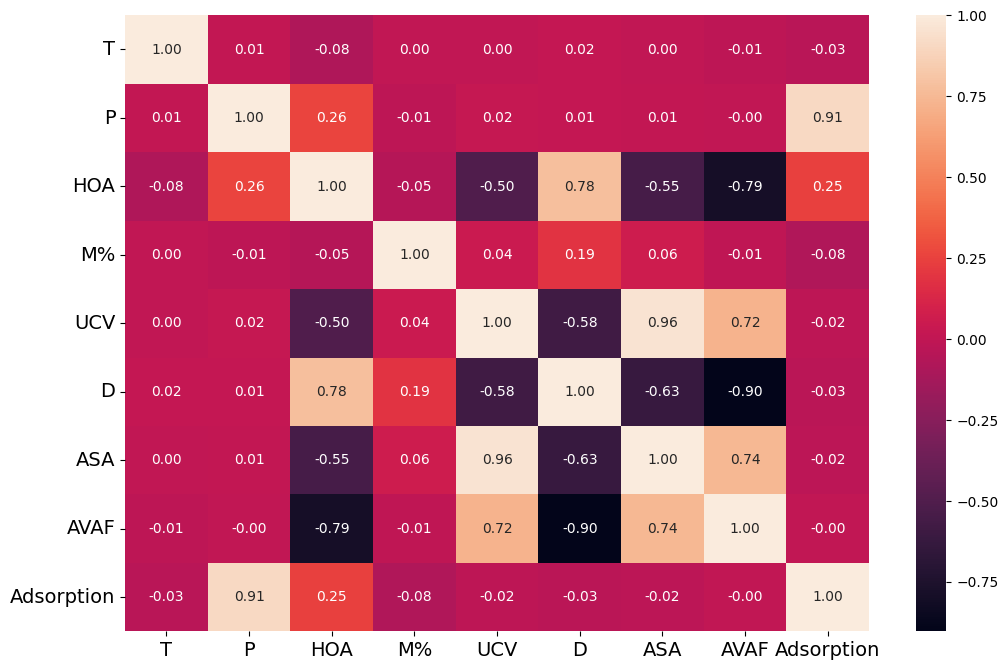

In [ ]:
plt.figure(figsize=(12,8))
numdf=df.select_dtypes(include='number')
sns.heatmap(numdf.corr(),annot=True,fmt='.2f')
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
plt.show()

Split data into training and testing set

In [ ]:
rem=['Filename','Metal node','Adsorption']
X_train,X_test,y_train,y_test=datasplit(df,rem,None)

Model training with hyperparmeter tuning

In [ ]:
bestmodelrf,bestscorerf=modeltrain(rfmodel,param_dist_rf,X_train,y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [ ]:
bestmodellg,bestscorelg=modeltrain(lgmodel,param_dist_lg,X_train,y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [ ]:
bestmodelxg,bestscorexg=modeltrain(xgmodel,param_dist_xg,X_train,y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


Best hyperparameters

In [ ]:
print(bestmodelrf)
print(bestmodellg)
print(bestmodelxg)
print(bestscorerf)
print(bestscorelg)
print(bestscorexg)

RandomForestRegressor(max_depth=19, max_features=7, min_samples_leaf=5,
                      min_samples_split=15, n_estimators=222, random_state=22)
LGBMRegressor(max_depth=12, n_estimators=872, objective='regression_l1',
              random_state=22, subsample=0.5, verbosity=-1)
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0.5, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=11,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=773,
             n_jobs=None,

Model performance metrics

In [ ]:
trainscorerf,testscorerf,rmsetrnr,rmserf,maetrnr,maerf,maperf,rfytpred,rfpred=modelresult(bestmodelrf,X_train,y_train,X_test,y_test)
trainscorelg,testscorelg,rmsetrlg,rmselg,maetrnlg,maelg,mapelg,lgytpred,lgpred=modelresult(bestmodellg,X_train,y_train,X_test,y_test)
trainscorexg,testscorexg,rmsetrxg,rmsexg,maetrnxg,maexg,mapexg,xgytpred,xgpred=modelresult(bestmodelxg,X_train,y_train,X_test,y_test)

Training R2 for RF is: 0.983939647222889
Testing R2 for RF is: 0.9765630896934389
Training RMSE for RF is: 0.7646585655352006
Testing RMSE for RF is: 0.9490872247309874
Training MAE for RF is: 0.41953209082926757
Testing MAE for RF is: 0.5610458339147762
MAPE for RF is: 0.2094019774515283


Training R2 for LGB is: 0.9868747873738515
Testing R2 for LGB is: 0.9775745172149326
Training RMSE for LGB is: 0.6912628081365491
Testing RMSE for LGB is: 0.9283822946122644
Training MAE for LGB is: 0.2836800516182105
Testing MAE for LGB is: 0.5365509935771923
MAPE for LGB is: 0.20328911678131856


Training R2 for XGB is: 0.9913384438712823
Testing R2 for XGB is: 0.9794437810660729
Training RMSE for XGB is: 0.5615494154118463
Testing RMSE for XGB is: 0.8888481356698263
Training MAE for XGB is: 0.30351367222095754
Testing MAE for XGB is: 0.525033818681971
MAPE for XGB is: 0.19868581596078666




Scatter plot for true and predicted values

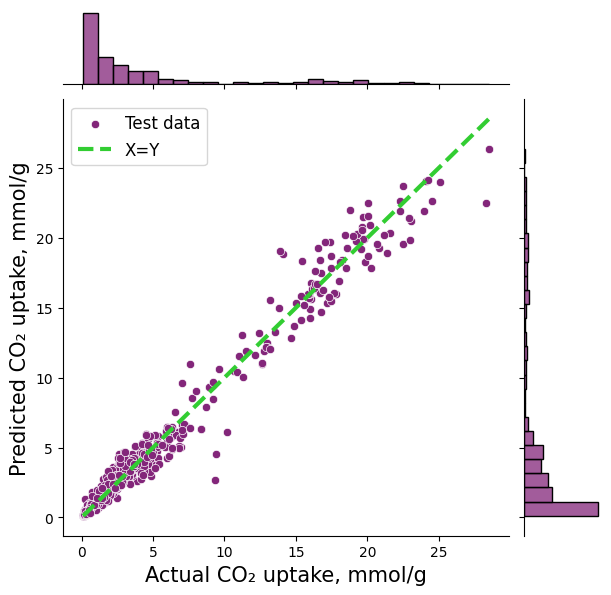

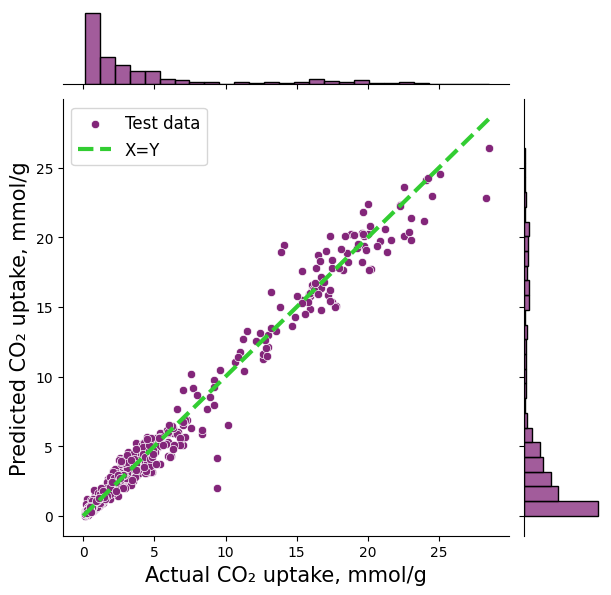

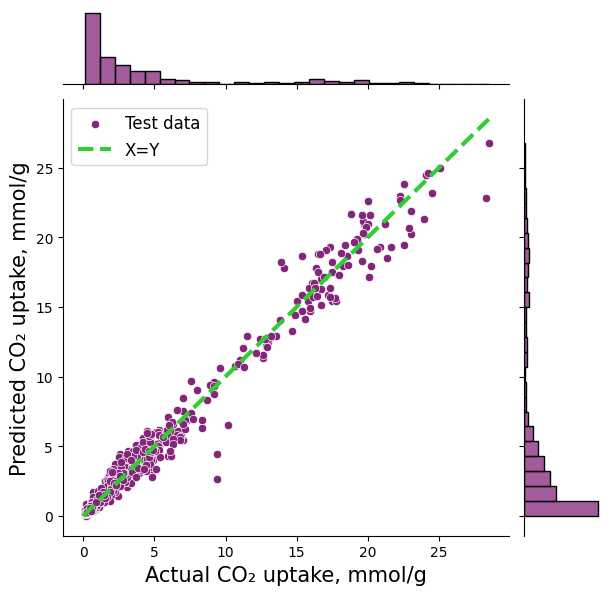

In [ ]:
rfplot = sns.jointplot(
    x=y_test,
    y=rfpred,
    label="Test data",
    color='#83267A'
)
min_val = min(y_test.min(), rfpred.min())
max_val = max(y_test.max(), rfpred.max())
rfplot.ax_joint.plot([min_val, max_val], [min_val, max_val], color="#32CD32",linestyle='--',linewidth=3,label='X=Y')
rfplot.ax_joint.set_xlabel("Actual CO₂ uptake, mmol/g", fontsize=15)
rfplot.ax_joint.set_ylabel("Predicted CO₂ uptake, mmol/g",fontsize=15)
rfplot.ax_joint.legend(loc='upper left',fontsize=12)
plt.show()

lgplot = sns.jointplot(
    x=y_test,
    y=lgpred,
    label="Test data",
    color='#83267A'
)
min_val = min(y_test.min(), lgpred.min())
max_val = max(y_test.max(), lgpred.max())
lgplot.ax_joint.plot([min_val, max_val], [min_val, max_val], color="#32CD32",linestyle='--',linewidth=3,label='X=Y')
lgplot.ax_joint.set_xlabel("Actual CO₂ uptake, mmol/g",fontsize=15)
lgplot.ax_joint.set_ylabel("Predicted CO₂ uptake, mmol/g",fontsize=15)
lgplot.ax_joint.legend(loc='upper left',fontsize=12)
plt.show()

xgplot = sns.jointplot(
    x=y_test,
    y=xgpred,
    label="Test data",
    color='#83267A'
)
min_val = min(y_test.min(), xgpred.min())
max_val = max(y_test.max(), xgpred.max())
xgplot.ax_joint.plot([min_val, max_val], [min_val, max_val], color="#32CD32",linestyle='--',linewidth=3,label='X=Y')
xgplot.ax_joint.set_xlabel("Actual CO₂ uptake, mmol/g",fontsize=15)
xgplot.ax_joint.set_ylabel("Predicted CO₂ uptake, mmol/g",fontsize=15)
xgplot.ax_joint.legend(loc='upper left',fontsize=12)
plt.show()

Residual plots

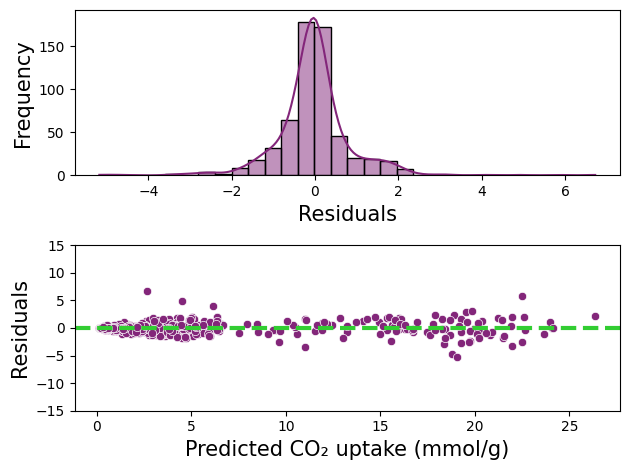

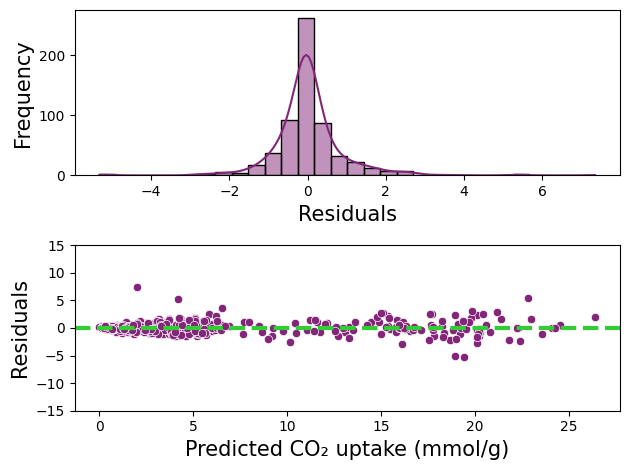

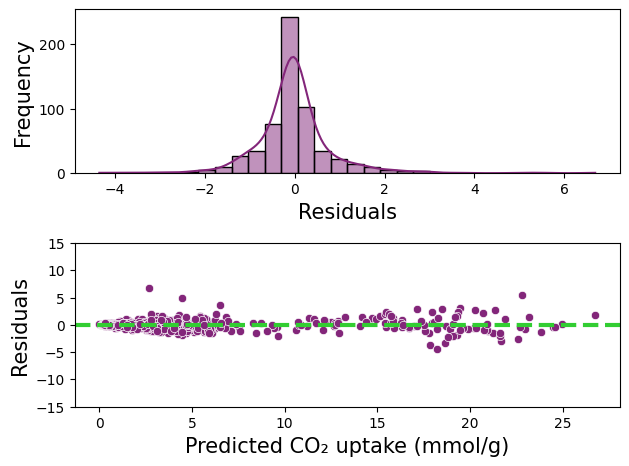

In [ ]:
residual1 = y_test - rfpred
residual2 = y_test - lgpred
residual3 = y_test - xgpred

#residual plots for RF model
fig, axes = plt.subplots(2, 1)

sns.histplot(residual1, kde=True, bins=30, ax=axes[0],color='#83267A')
axes[0].set_xlabel("Residuals",fontsize=15)
axes[0].set_ylabel("Frequency",fontsize=15)

sns.scatterplot(x=rfpred, y=residual1, ax=axes[1],color='#83267A')
axes[1].axhline(0, color="#32CD32",linestyle='--',linewidth=3)
axes[1].set_xlabel("Predicted CO₂ uptake (mmol/g)",fontsize=15)
axes[1].set_ylabel("Residuals",fontsize=15)
axes[1].set_ylim(-15, 15)
axes[1].yaxis.set_major_locator(plt.MultipleLocator(5))

plt.tight_layout()
plt.show()

#residual plots for LGB model
fig, axes = plt.subplots(2, 1)

sns.histplot(residual2, kde=True, bins=30, ax=axes[0],color='#83267A')
axes[0].set_xlabel("Residuals",fontsize=15)
axes[0].set_ylabel("Frequency",fontsize=15)

sns.scatterplot(x=lgpred, y=residual2, ax=axes[1],color='#83267A')
axes[1].axhline(0, color="#32CD32",linestyle='--',linewidth=3)
axes[1].set_xlabel("Predicted CO₂ uptake (mmol/g)",fontsize=15)
axes[1].set_ylabel("Residuals",fontsize=15)
axes[1].set_ylim(-15, 15)
axes[1].yaxis.set_major_locator(plt.MultipleLocator(5))

plt.tight_layout()
plt.show()

#residual plots for XGB model
fig, axes = plt.subplots(2, 1)

sns.histplot(residual3, kde=True, bins=30, ax=axes[0],color='#83267A')
axes[0].set_xlabel("Residuals",fontsize=15)
axes[0].set_ylabel("Frequency",fontsize=15)

sns.scatterplot(x=xgpred, y=residual3, ax=axes[1],color='#83267A')
axes[1].axhline(0, color="#32CD32",linestyle='--',linewidth=3)
axes[1].set_xlabel("Predicted CO₂ uptake (mmol/g)",fontsize=15)
axes[1].set_ylabel("Residuals",fontsize=15)
axes[1].set_ylim(-15, 15)
axes[1].yaxis.set_major_locator(plt.MultipleLocator(5))

plt.tight_layout()
plt.show()

In [ ]:
trured=pd.DataFrame({'Actual':y_test,'residual1':(y_test-rfpred),'residual2':(y_test-lgpred),'residual3':(y_test-xgpred)})
X_testdiag=X_test.copy()
X_testdiag['residual1']=trured['residual1']
X_testdiag['residual2']=trured['residual2']
X_testdiag['residual3']=trured['residual3']
X_testdiag['adsorption (mmol/g)']=y_test
X_testdiag['rfprediction']=rfpred
X_testdiag['lgprediction']=lgpred
X_testdiag['xgprediction']=xgpred

In [ ]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))

/tmp/ipython-input-121871771.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  results01 = Xcpy.groupby("bin").apply(
/tmp/ipython-input-121871771.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results01 = Xcpy.groupby("bin").apply(


Model analysis at different temperature and pressure

In [ ]:
for T in [298, 313, 338]:
    print(f"{T}K:")

    print(r2_score(X_testdiag[X_testdiag['T']==T]['adsorption (mmol/g)'],
                    X_testdiag[X_testdiag['T']==T]['rfprediction']))
    print(root_mean_squared_error(X_testdiag[X_testdiag['T']==T]['adsorption (mmol/g)'],
                                  X_testdiag[X_testdiag['T']==T]['rfprediction']))
    print(mean_absolute_error(X_testdiag[X_testdiag['T']==T]['adsorption (mmol/g)'],
                              X_testdiag[X_testdiag['T']==T]['rfprediction']))
    print(mean_absolute_percentage_error(X_testdiag[X_testdiag['T']==T]['adsorption (mmol/g)'],
                              X_testdiag[X_testdiag['T']==T]['rfprediction']))

    print(r2_score(X_testdiag[X_testdiag['T']==T]['adsorption (mmol/g)'],
                    X_testdiag[X_testdiag['T']==T]['lgprediction']))
    print(root_mean_squared_error(X_testdiag[X_testdiag['T']==T]['adsorption (mmol/g)'],
                                  X_testdiag[X_testdiag['T']==T]['lgprediction']))
    print(mean_absolute_error(X_testdiag[X_testdiag['T']==T]['adsorption (mmol/g)'],
                              X_testdiag[X_testdiag['T']==T]['lgprediction']))
    print(mean_absolute_percentage_error(X_testdiag[X_testdiag['T']==T]['adsorption (mmol/g)'],
                              X_testdiag[X_testdiag['T']==T]['lgprediction']))

    print(r2_score(X_testdiag[X_testdiag['T']==T]['adsorption (mmol/g)'],
                    X_testdiag[X_testdiag['T']==T]['xgprediction']))
    print(root_mean_squared_error(X_testdiag[X_testdiag['T']==T]['adsorption (mmol/g)'],
                                  X_testdiag[X_testdiag['T']==T]['xgprediction']))
    print(mean_absolute_error(X_testdiag[X_testdiag['T']==T]['adsorption (mmol/g)'],
                              X_testdiag[X_testdiag['T']==T]['xgprediction']))
    print(mean_absolute_percentage_error(X_testdiag[X_testdiag['T']==T]['adsorption (mmol/g)'],
                              X_testdiag[X_testdiag['T']==T]['xgprediction']))

    print("\n")

298K:
0.7303239717282435
0.8517423295161359
0.46726931159542734
0.29242129991553745
0.7253930851730183
0.8594938904600139
0.4516126947554257
0.2702591683452333
0.7371401869266111
0.8409093024561387
0.4547123691858232
0.2791925794868476


313K:
0.9778582812314129
1.2184826145888947
0.7903165603080657
0.1400604526203644
0.9790296990888595
1.185812442630463
0.7522925905958243
0.1461921406279171
0.9814037783421088
1.1166730345804403
0.7175269664268674
0.12791163557972884


338K:
0.9134393431012132
0.6628950370799152
0.4046021150032734
0.20262081862410752
0.9227647728570243
0.6261699325949487
0.3860680734230689
0.19907917918003434
0.926055655707019
0.6126846176512343
0.38535942089139896
0.19594899996209175




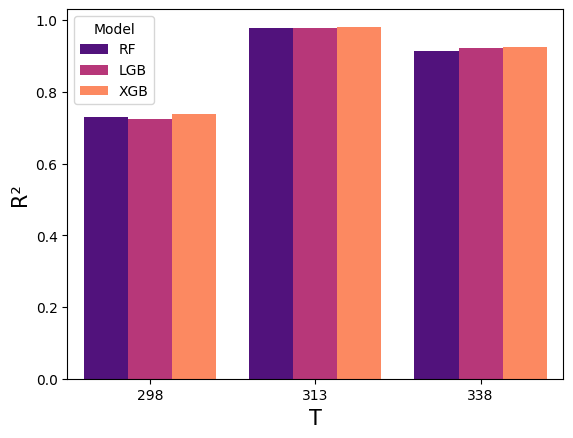

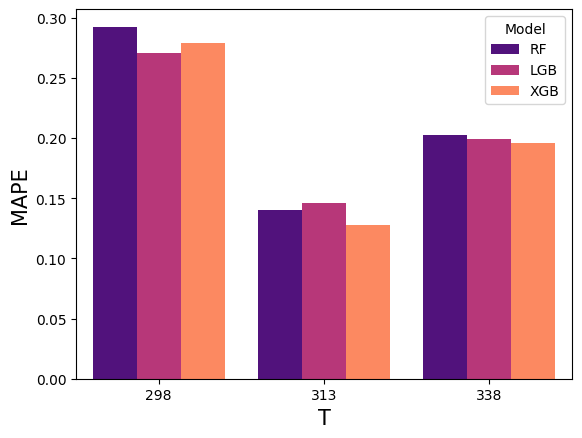

In [ ]:
temperatures = [298, 313, 338]
models = {
    "RF": "rfprediction",
    "LGB": "lgprediction",
    "XGB": "xgprediction"
}
results = []
for t in temperatures:
    subset = X_testdiag[X_testdiag['T']==t]
    y_true = subset['adsorption (mmol/g)']

    for model_name, pred_col in models.items():
        y_pred = subset[pred_col]

        results.append({
            "T": t,
            "Model": model_name,
            "R²": r2_score(y_true, y_pred),
            "MAPE": mean_absolute_percentage_error(y_true, y_pred)
        })

results_df = pd.DataFrame(results)

metrics = ["R²", "MAPE"]
for i, metric in enumerate(metrics):
    sns.barplot(
        data=results_df,
        x="T",
        y=metric,
        hue="Model",
        palette = 'magma',
        saturation=1,
    )
    plt.xlabel("T",fontsize=15)
    plt.ylabel(metric,fontsize=15)
    plt.show()

In [ ]:
for p in [0.1, 0.26, 0.4, 1, 3.2, 16]:

  print(f"Pressure:{p}")
  print(r2_score(X_testdiag[X_testdiag['P']==p]['adsorption (mmol/g)'],
                  X_testdiag[X_testdiag['P']==p]['rfprediction']))
  print(root_mean_squared_error(X_testdiag[X_testdiag['P']==p]['adsorption (mmol/g)'],
                                X_testdiag[X_testdiag['P']==p]['rfprediction']))
  print(mean_absolute_error(X_testdiag[X_testdiag['P']==p]['adsorption (mmol/g)'],
                            X_testdiag[X_testdiag['P']==p]['rfprediction']))
  print(mean_absolute_percentage_error(X_testdiag[X_testdiag['P']==p]['adsorption (mmol/g)'],
                            X_testdiag[X_testdiag['P']==p]['rfprediction']))

  print(r2_score(X_testdiag[X_testdiag['P']==p]['adsorption (mmol/g)'],
                  X_testdiag[X_testdiag['P']==p]['lgprediction']))
  print(root_mean_squared_error(X_testdiag[X_testdiag['P']==p]['adsorption (mmol/g)'],
                                X_testdiag[X_testdiag['P']==p]['lgprediction']))
  print(mean_absolute_error(X_testdiag[X_testdiag['P']==p]['adsorption (mmol/g)'],
                            X_testdiag[X_testdiag['P']==p]['lgprediction']))
  print(mean_absolute_percentage_error(X_testdiag[X_testdiag['P']==p]['adsorption (mmol/g)'],
                            X_testdiag[X_testdiag['P']==p]['lgprediction']))

  print(r2_score(X_testdiag[X_testdiag['P']==p]['adsorption (mmol/g)'],
                  X_testdiag[X_testdiag['P']==p]['xgprediction']))
  print(root_mean_squared_error(X_testdiag[X_testdiag['P']==p]['adsorption (mmol/g)'],
                                X_testdiag[X_testdiag['P']==p]['xgprediction']))
  print(mean_absolute_error(X_testdiag[X_testdiag['P']==p]['adsorption (mmol/g)'],
                            X_testdiag[X_testdiag['P']==p]['xgprediction']))
  print(mean_absolute_percentage_error(X_testdiag[X_testdiag['P']==p]['adsorption (mmol/g)'],
                            X_testdiag[X_testdiag['P']==p]['xgprediction']))

  print("\n")

Pressure:0.1
0.6929697520155653
0.3153185358221467
0.1878324203244829
0.321957524337146
0.727117858936523
0.2972668468489531
0.19132961595208386
0.307518202497963
0.7194772468463553
0.30139980420445917
0.18577195648889647
0.3142376127119825


Pressure:0.26
0.8318447015740184
0.19959156982939433
0.11466621907728496
0.23678154440436847
0.8370666105561724
0.19646806235246006
0.12383571592005169
0.24922199204352177
0.8820168826992413
0.16718482283499078
0.11043925992941665
0.238885653605567


Pressure:0.4
0.9010208427212731
0.3645795345214482
0.24265288544154548
0.20752070407931347
0.8876389182809763
0.3884439538089145
0.2780424765018565
0.23071573982346089
0.9090920923673959
0.3493986649326826
0.23599721951249777
0.19542033818018437


Pressure:1
0.47743104320305807
1.1435390100762486
0.7271456204774054
0.2649526112034416
0.46309082458569717
1.1591231881795314
0.6936759580425335
0.23560826658319456
0.488383073106041
1.1314923795727738
0.7048269529939649
0.24660069858747224


Pressure:3.2
0

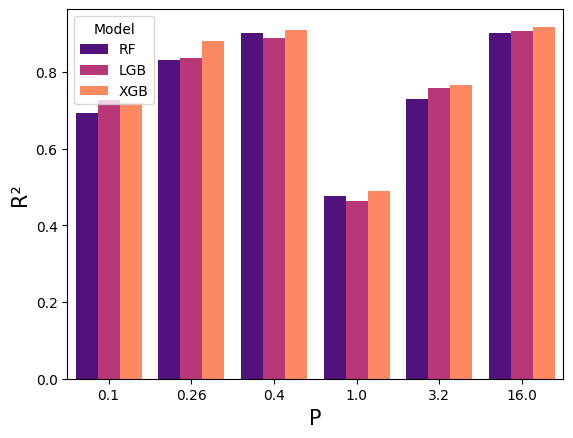

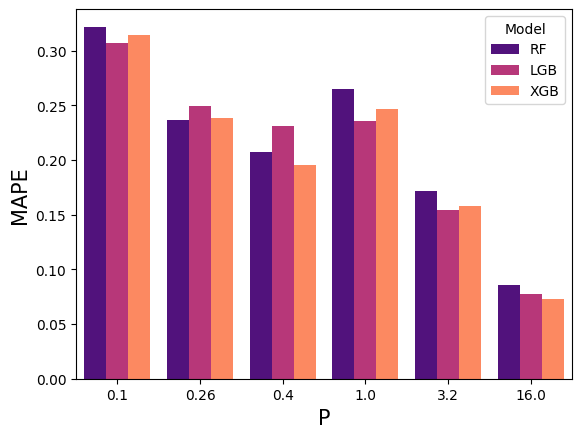

In [ ]:
models = {
    "RF": "rfprediction",
    "LGB": "lgprediction",
    "XGB": "xgprediction"
}
results2 = []
for p in [0.1, 0.26, 0.4, 1, 3.2, 16]:
    subset2 = X_testdiag[X_testdiag['P']==p]
    y_true2 = subset2['adsorption (mmol/g)']

    for model_name, pred_col in models.items():
        y_pred2 = subset2[pred_col]

        results2.append({
            "P": p,
            "Model": model_name,
            "R²": r2_score(y_true2, y_pred2),
            "MAPE": mean_absolute_percentage_error(y_true2, y_pred2)
        })

results2_df = pd.DataFrame(results2)

metrics = ["R²","MAPE"]
for i, metric in enumerate(metrics):
    sns.barplot(
        data=results2_df,
        x="P",
        y=metric,
        hue="Model",
        palette = 'magma',
        saturation=1,
    )
    plt.xlabel("P",fontsize=15)
    plt.ylabel(metric,fontsize=15)
    plt.show()


SHAP bar plot

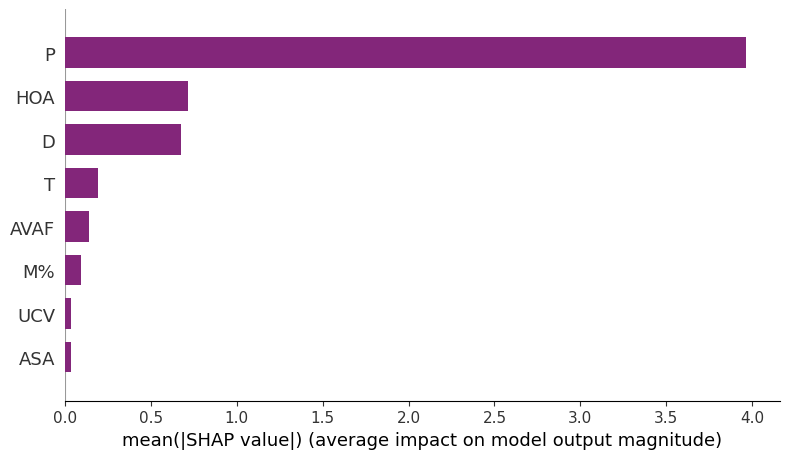

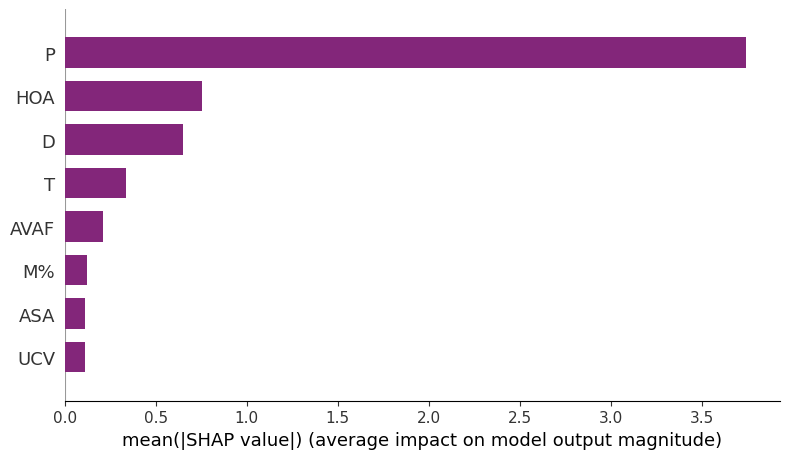

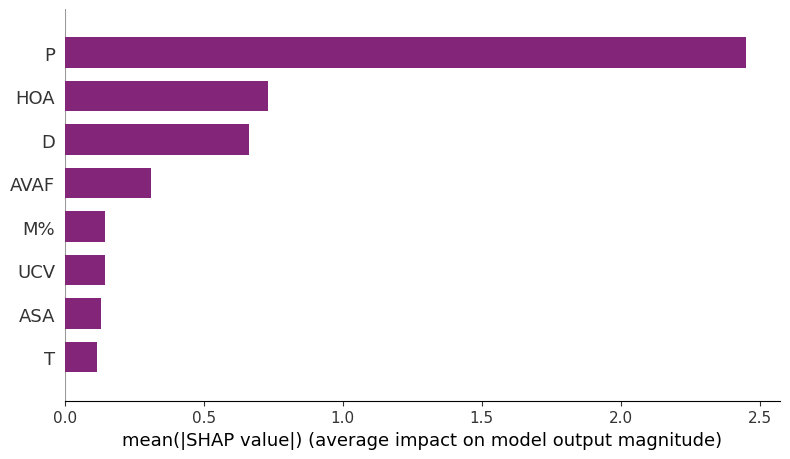

In [ ]:

explainer_rf = shap.TreeExplainer(bestmodelrf)
shap_values_rf = explainer_rf.shap_values(X_train)
shap.summary_plot(shap_values_rf, X_train, plot_type="bar",color="#83267A")

explainer_lg = shap.TreeExplainer(bestmodellg)
shap_values_lg = explainer_lg.shap_values(X_train)
shap.summary_plot(shap_values_lg, X_train, plot_type="bar",color="#83267A")

explainer_xg = shap.TreeExplainer(bestmodelxg)
shap_values_xg = explainer_xg.shap_values(X_train.values)
shap.summary_plot(shap_values_xg, X_train, plot_type="bar",color="#83267A")



SHAP beeswarm plot

In [ ]:
shap.summary_plot(shap_values_rf, X_train, plot_type="dot")
shap.summary_plot(shap_values_lg, X_train, plot_type="dot")
shap.summary_plot(shap_values_xg, X_train, plot_type="dot")

Feature importance by feature types

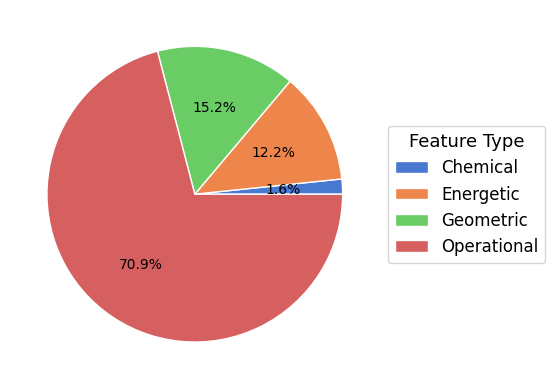

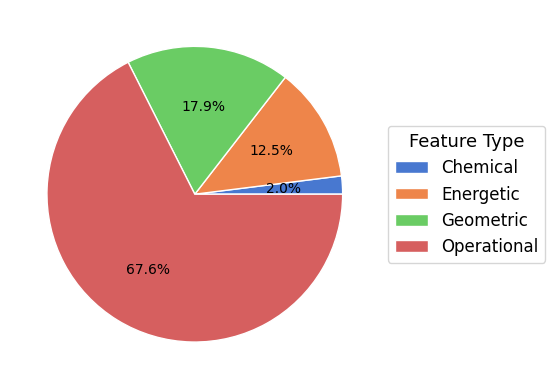

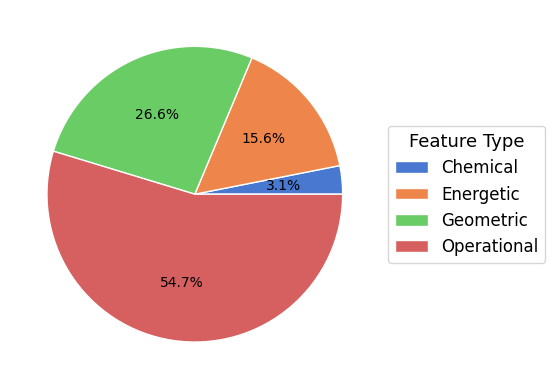

In [ ]:
shap_dict = {
    'Random Forest': shap_values_rf,
    'LightGBM': shap_values_lg,
    'XGBoost': shap_values_xg
}

feature_types = {
    'T': 'Operational',
    'P': 'Operational',
    'HOA': 'Energetic',
    'M%': 'Chemical',
    'UCV': 'Geometric',
    'D': 'Geometric',
    'ASA': 'Geometric',
    'AVAF': 'Geometric'
}

for model_name, shap_values in shap_dict.items():
    feature_importance = np.abs(shap_values).mean(axis=0)
    df = pd.DataFrame({
        'Feature': X_train.columns,
        'Mean_abs_SHAP': feature_importance
    })
    df['Feature Type'] = df['Feature'].map(feature_types)
    type_importance = df.groupby('Feature Type')['Mean_abs_SHAP'].sum().reset_index()

    colors = sns.color_palette("muted")
    wedges, texts, autotexts=plt.pie(
        type_importance['Mean_abs_SHAP'],
        labels=None,
        colors=colors,
        autopct='%1.1f%%',
        wedgeprops={'edgecolor': 'white'},
    )
    plt.legend(
        wedges,
        type_importance['Feature Type'],
        title="Feature Type",
        loc="center left",
        bbox_to_anchor=(1, 0, 0.5, 1),
        fontsize=12,
        title_fontsize=13
    )
    plt.show()

Partial dependence plots

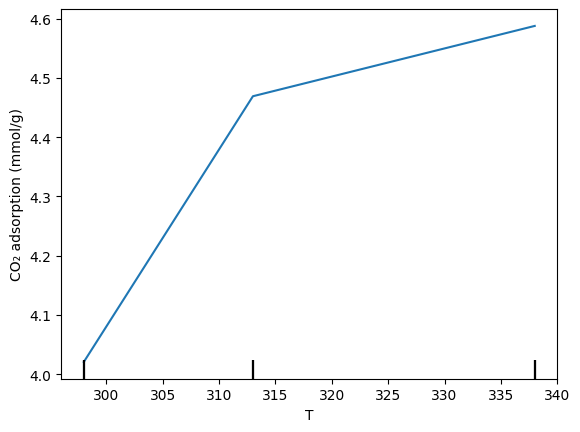

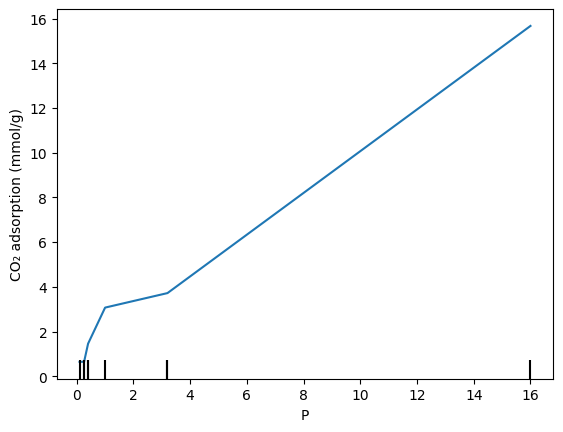

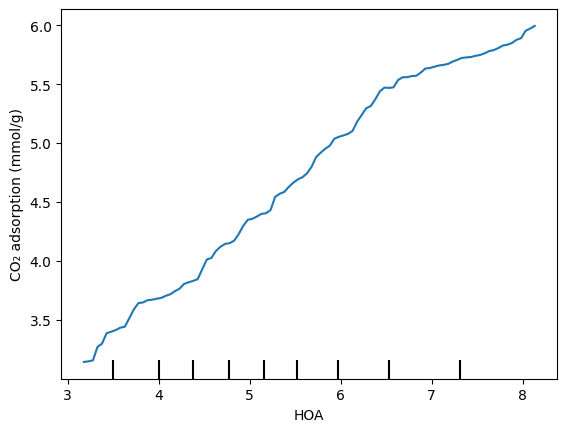

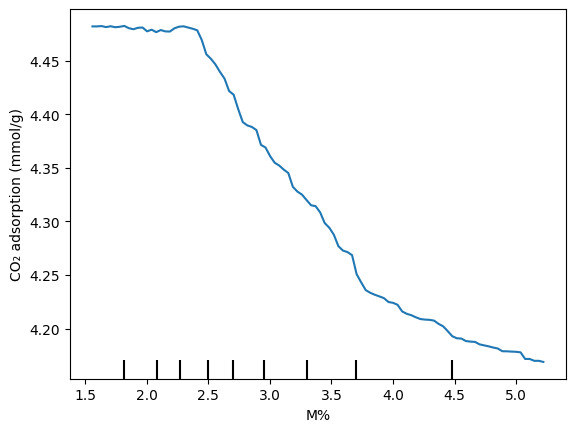

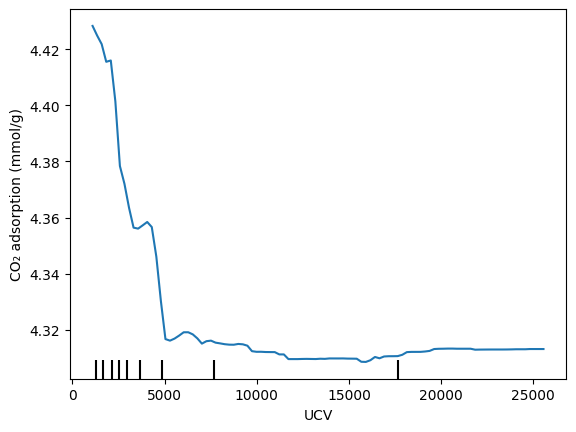

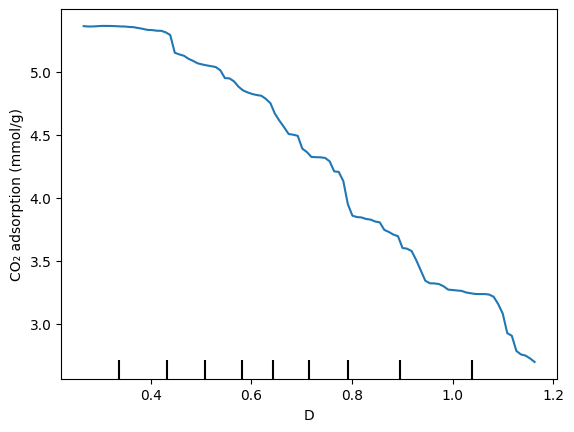

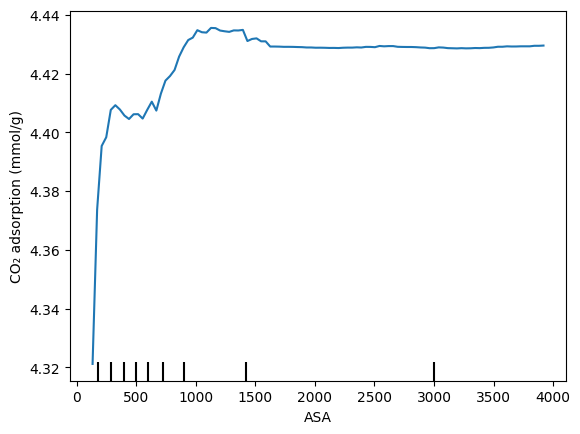

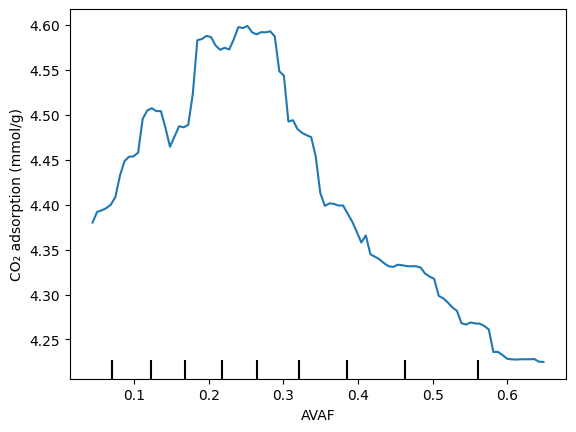

In [ ]:
for feat in X_train.columns:
  disp=PartialDependenceDisplay.from_estimator(
      bestmodelrf,
      X_train,
      features=[feat],
      kind="average"
  )
  plt.ylabel("CO₂ adsorption (mmol/g)")
  plt.show()

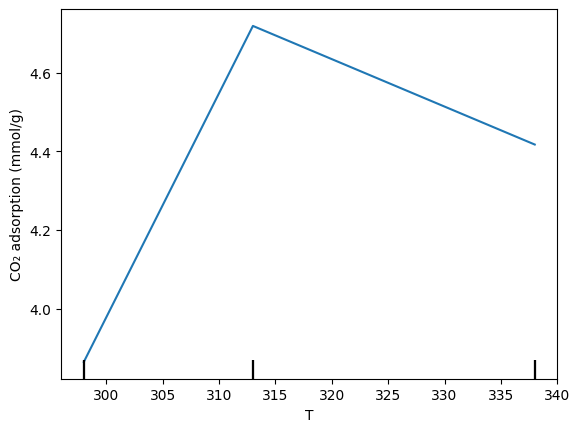

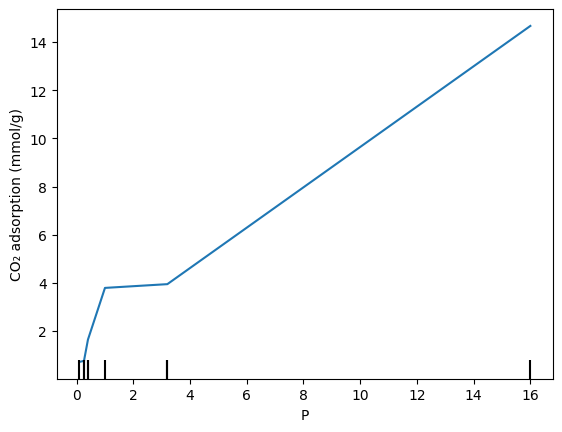

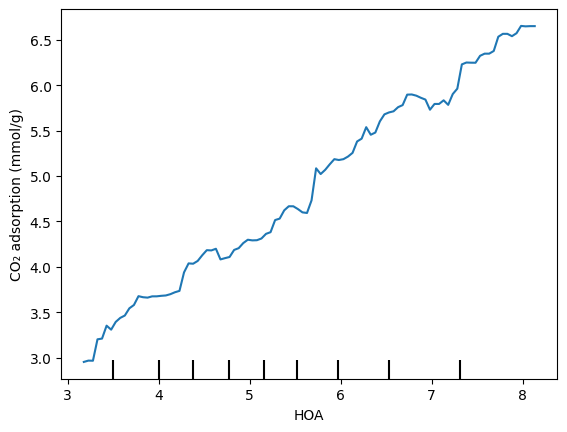

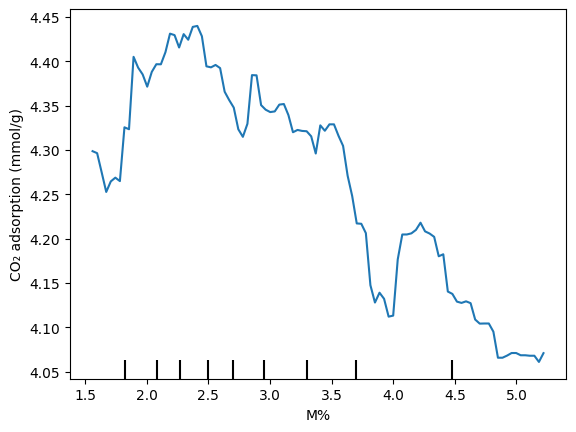

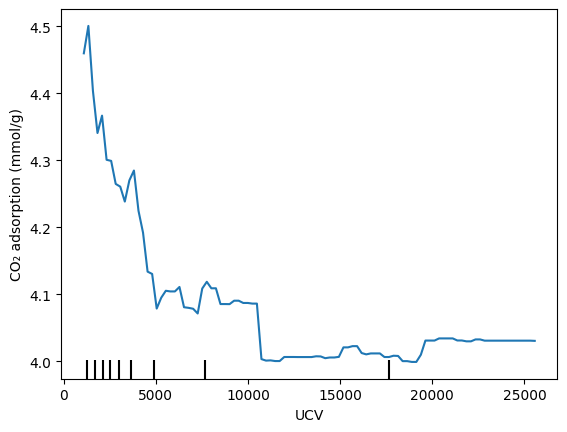

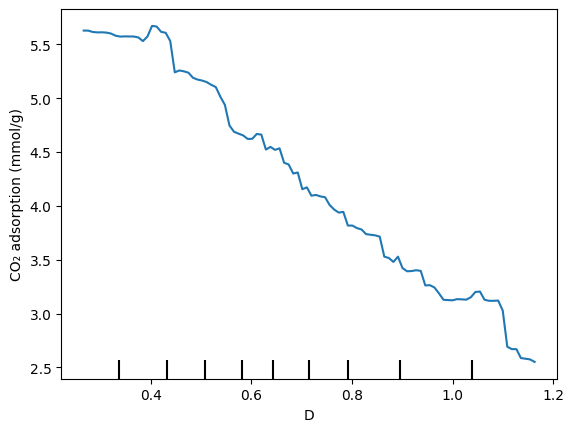

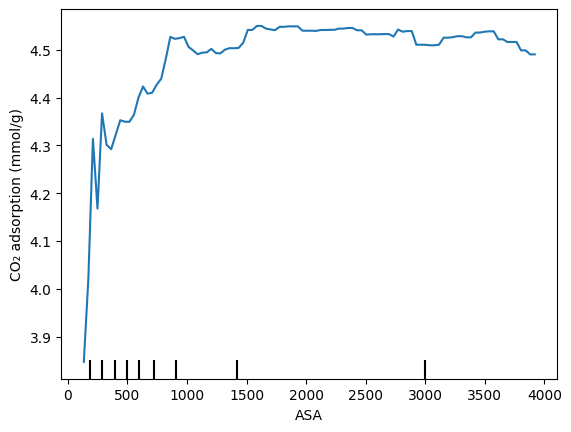

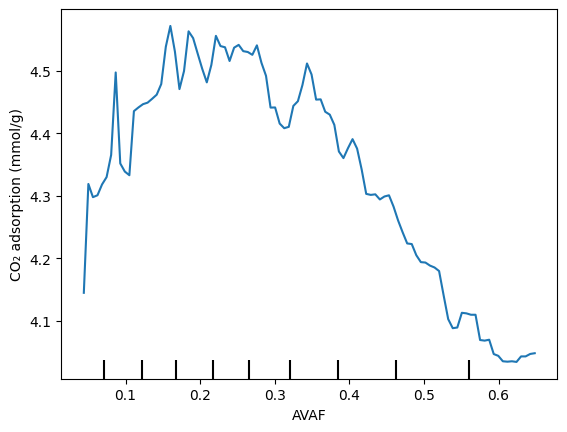

In [ ]:
for feat in X_train.columns:
  disp1=PartialDependenceDisplay.from_estimator(
      bestmodellg,
      X_train,
      features=[feat],
      kind="average"
  )
  plt.ylabel("CO₂ adsorption (mmol/g)")
  plt.show()

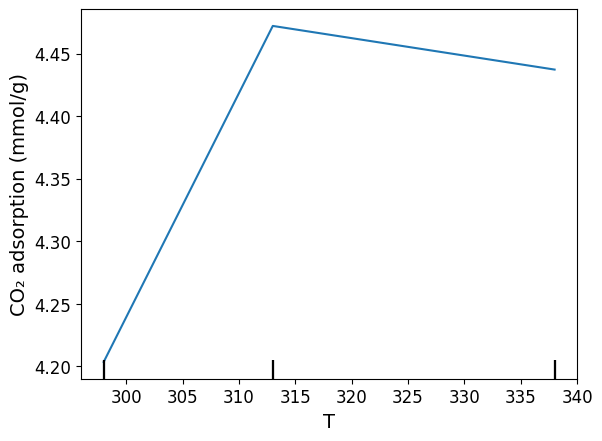

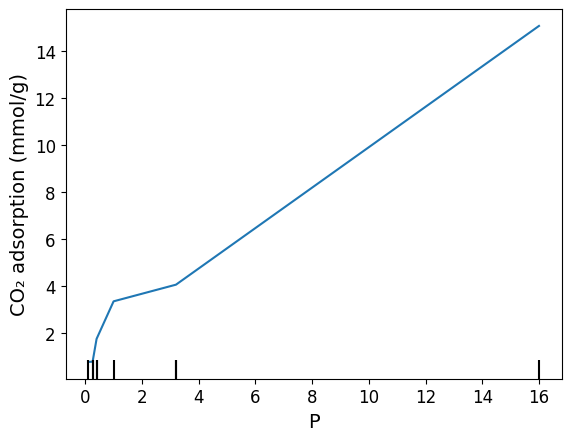

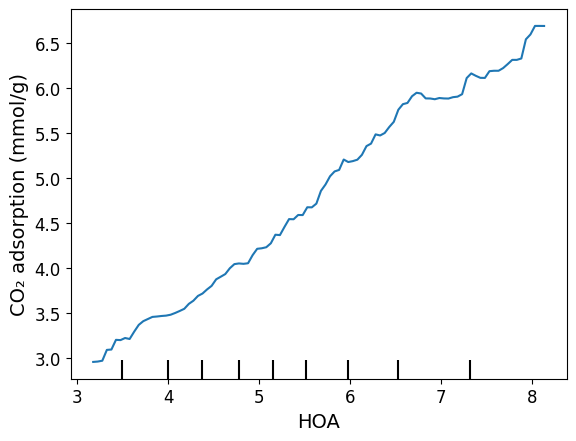

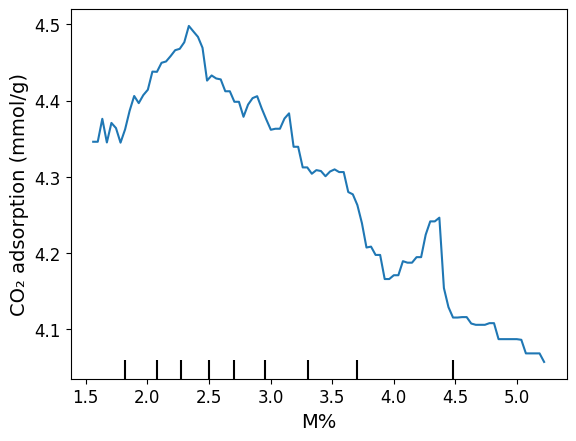

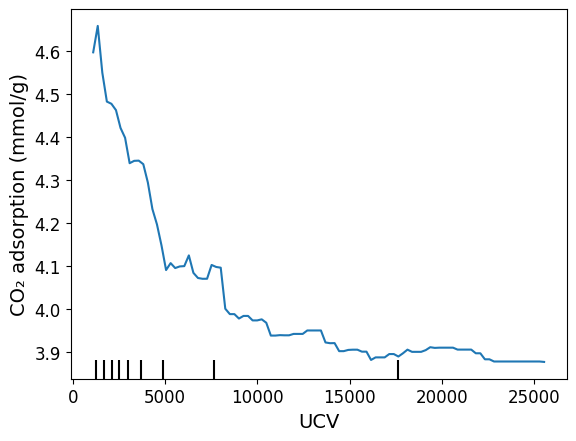

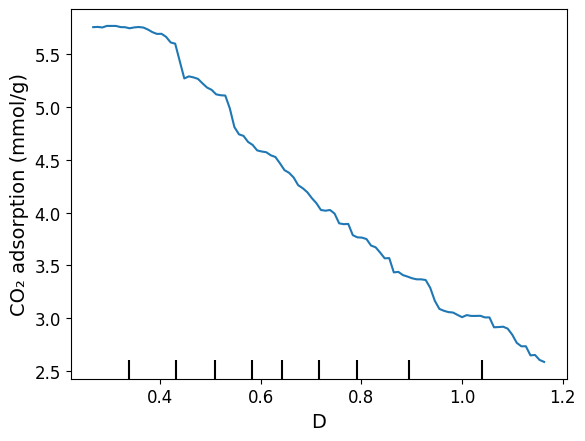

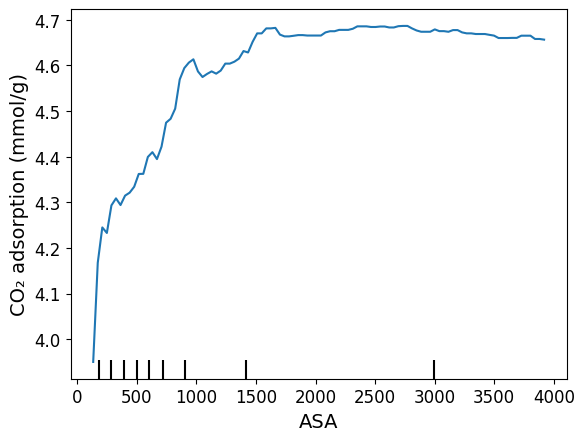

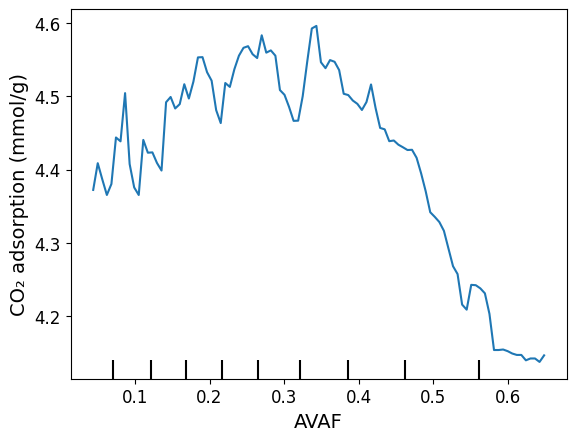

In [ ]:
max_info = {}

for feat in X_train.columns:

    disp2 = PartialDependenceDisplay.from_estimator(
        bestmodelxg,
        X_train,
        features=[feat],
        kind="average"
    )

    x = disp2.lines_[0][0].get_xdata()
    y = disp2.lines_[0][0].get_ydata()

    idx_max = np.argmax(y)

    max_info[feat] = (x[idx_max], y[idx_max])
    plt.xlabel(f"{feat}",fontsize=14)
    plt.ylabel("CO₂ adsorption (mmol/g)",fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

In [ ]:
for feat, (f_val, pred_val) in max_info.items():
    print(f"Feature: {feat}, Max Feature Value: {f_val}, Max Predicted Value: {pred_val}")

Feature: T(K), Max Feature Value: 313.0, Max Predicted Value: 4.472128868103027
Feature: Pressure(bar), Max Feature Value: 16.0, Max Predicted Value: 15.068642616271973
Feature: hoa (kcal/mol), Max Feature Value: 8.033832629797981, Max Predicted Value: 6.695054531097412
Feature: Metal%, Max Feature Value: 2.3363636363636364, Max Predicted Value: 4.49808931350708
Feature: UC_volume, Max Feature Value: 1338.966202020202, Max Predicted Value: 4.659178256988525
Feature: Density, Max Feature Value: 0.30275458484848483, Max Predicted Value: 5.768898963928223
Feature: ASA, Max Feature Value: 2733.566596868687, Max Predicted Value: 4.686563968658447
Feature: AVAf, Max Feature Value: 0.34323190303030315, Max Predicted Value: 4.595995903015137


SHAP dependence plots

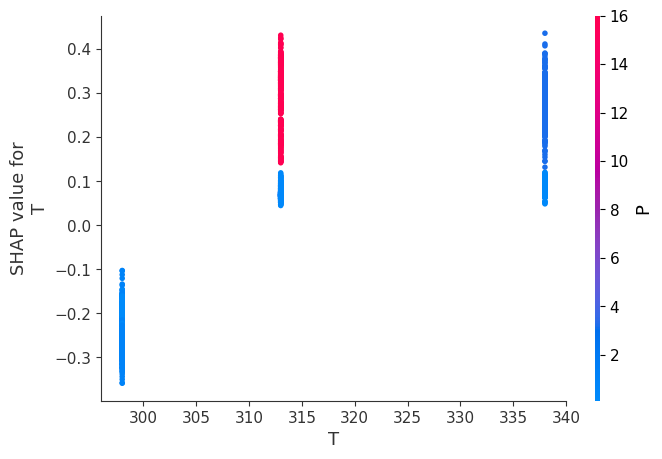

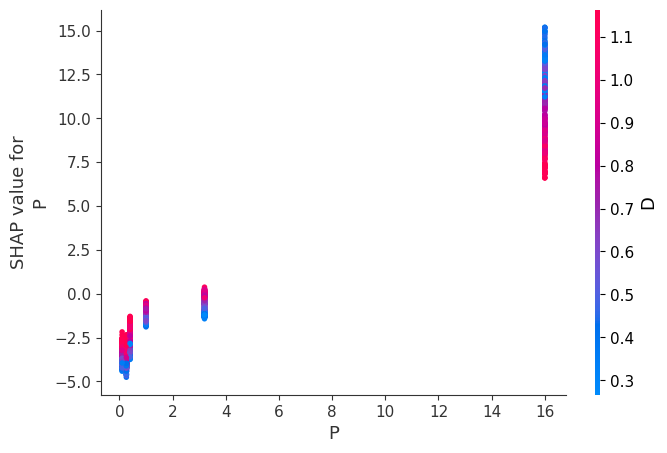

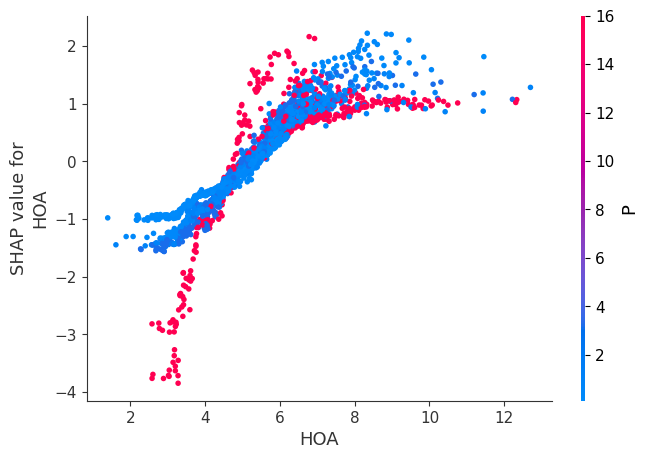

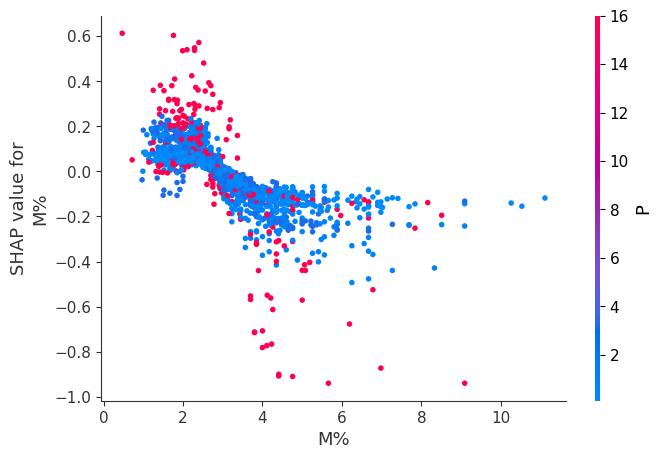

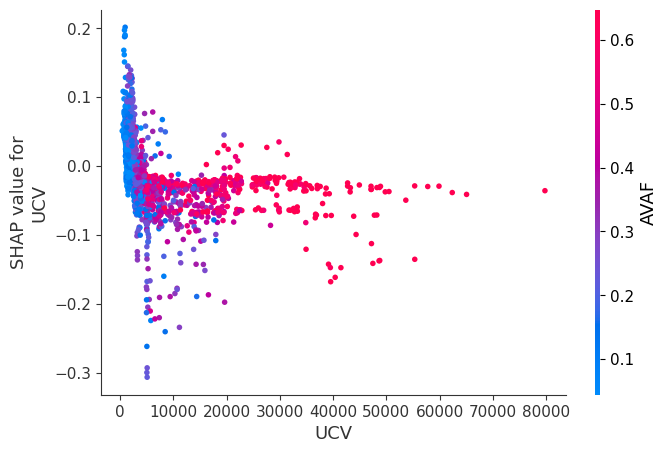

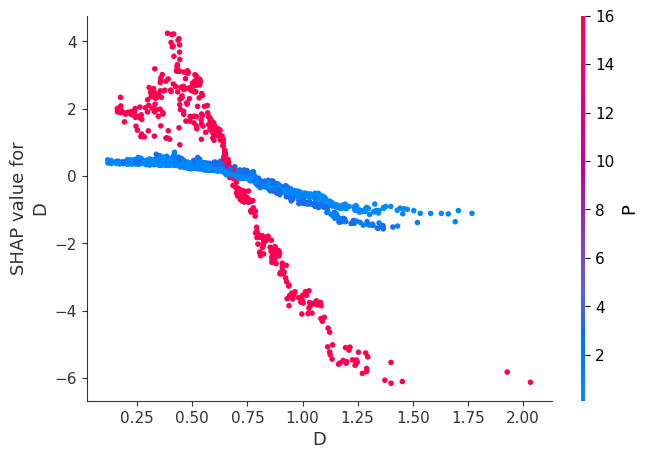

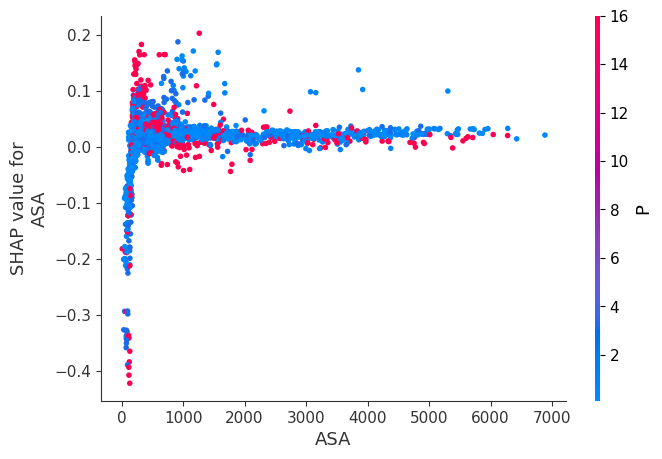

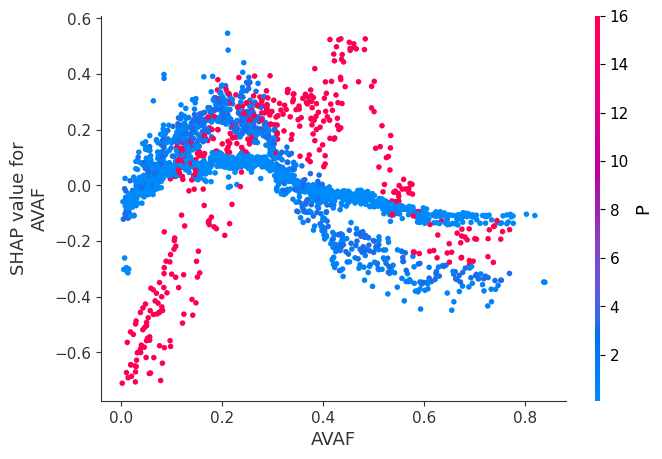

In [ ]:
feature_names = X_train.columns.tolist()
for feature in feature_names:
    shap.dependence_plot(feature, shap_values_rf, X_train, interaction_index="auto")

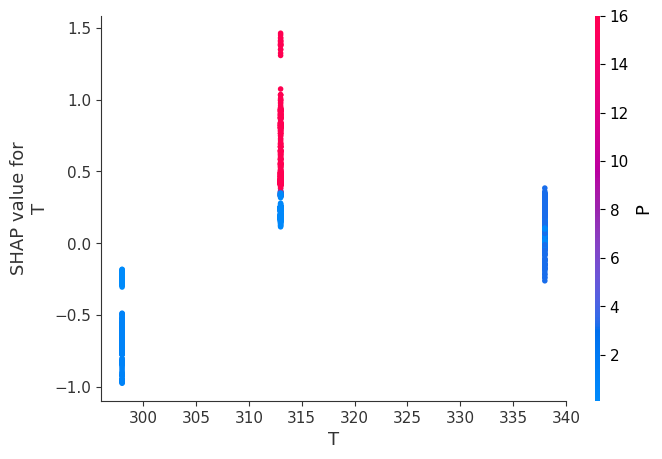

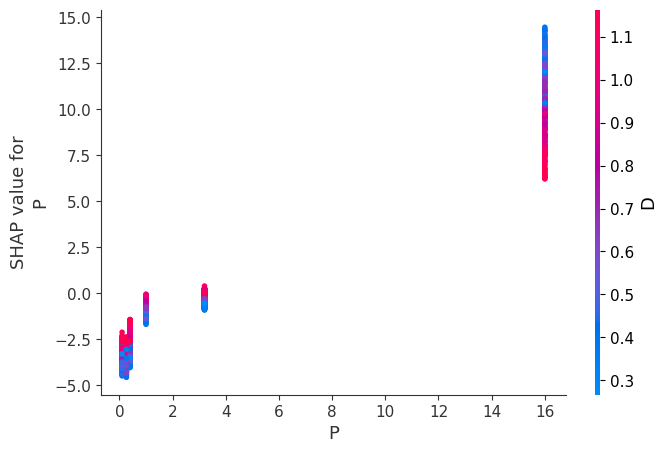

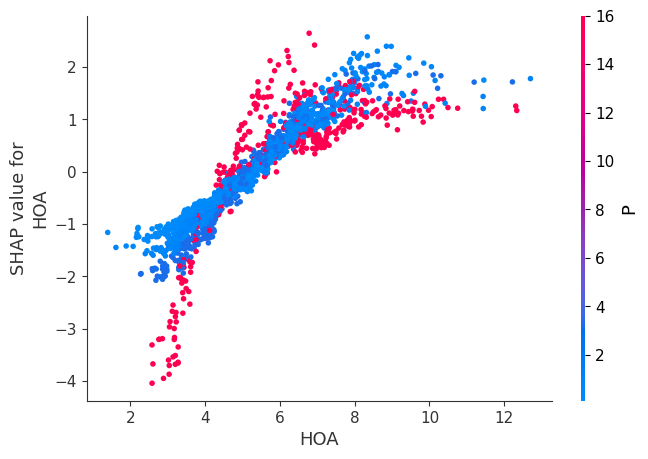

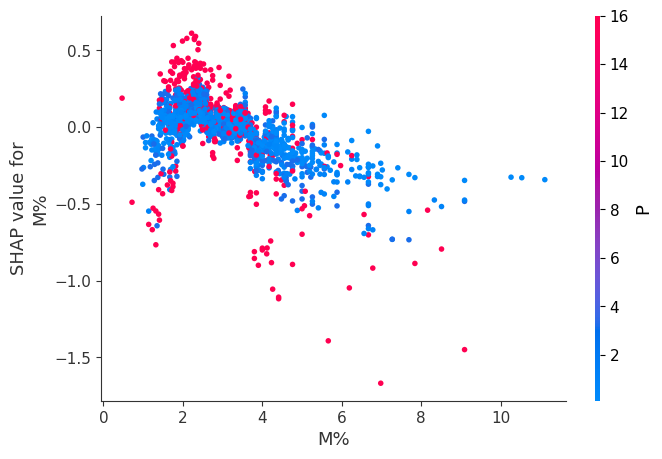

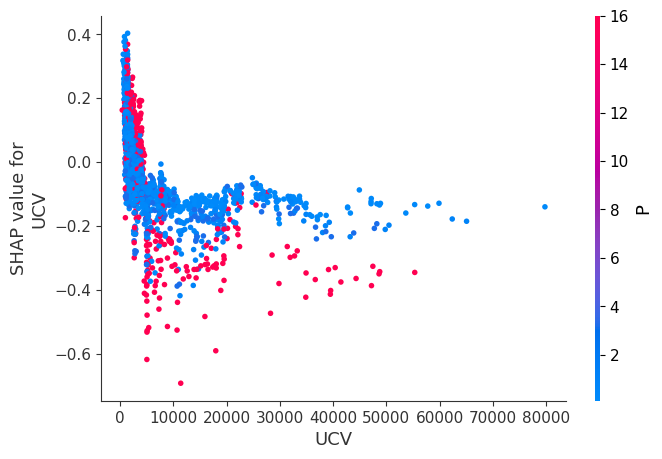

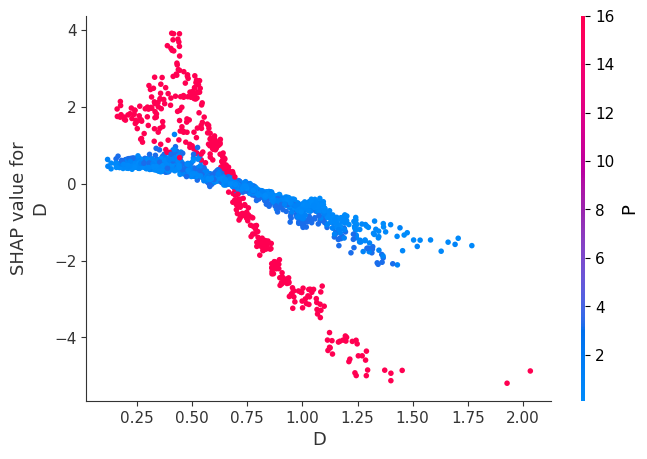

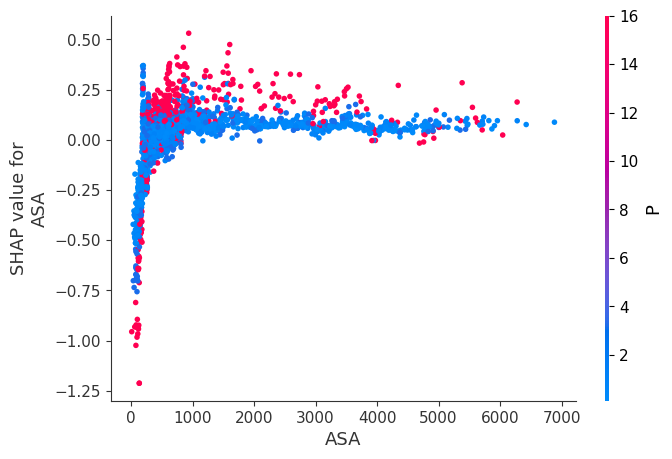

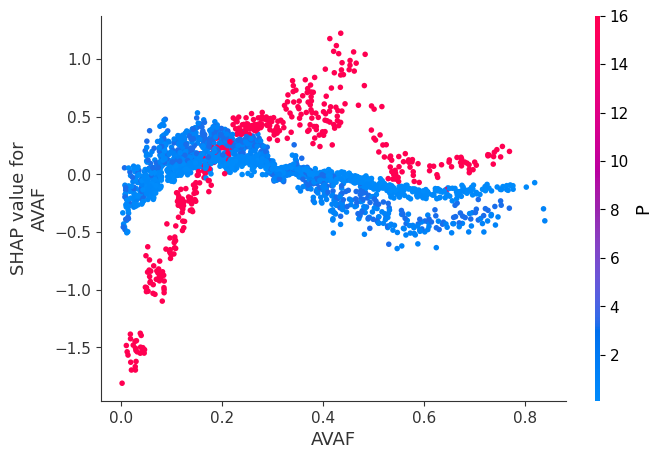

In [ ]:
for feature in feature_names:
    shap.dependence_plot(feature, shap_values_lg, X_train, interaction_index="auto")

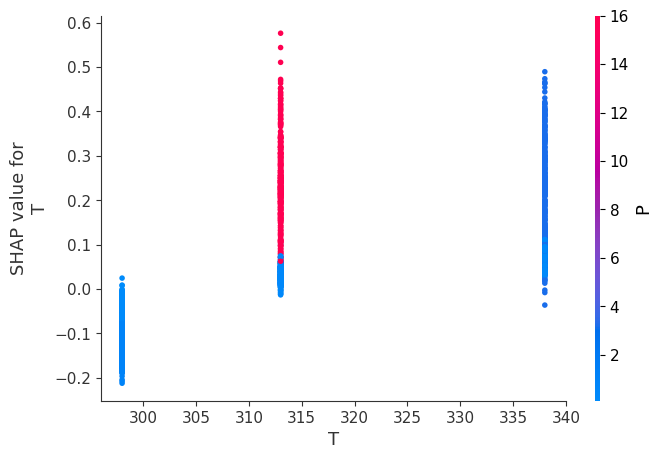

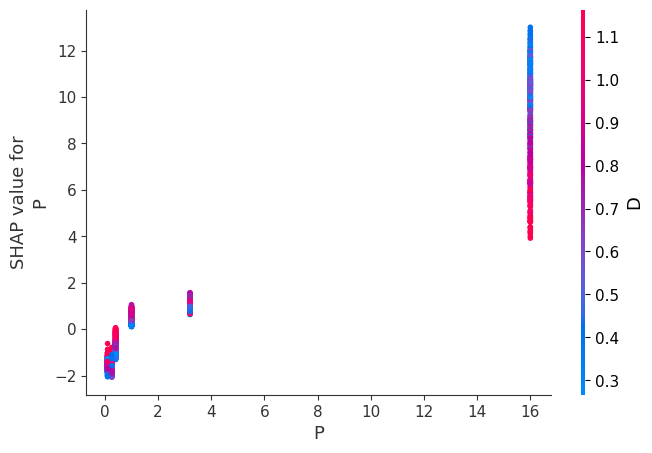

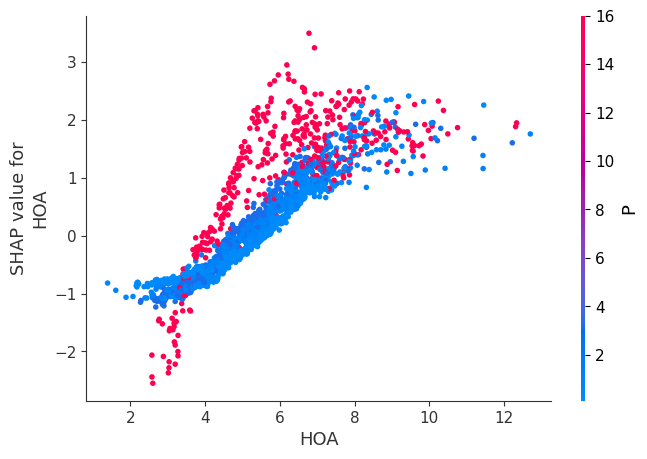

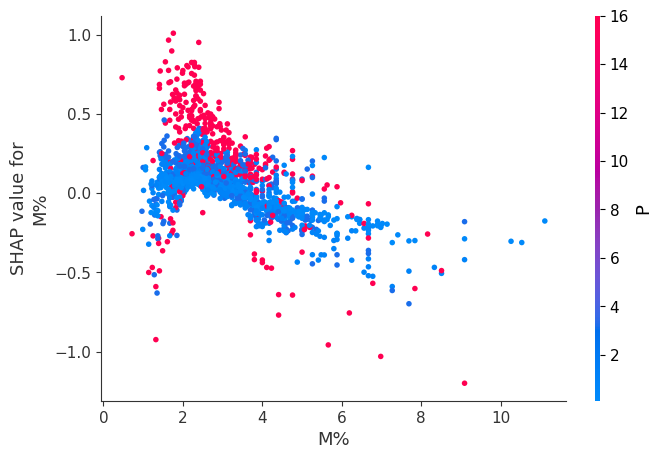

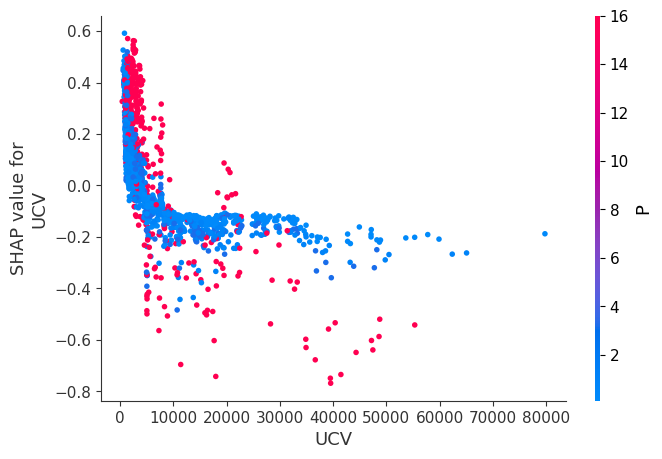

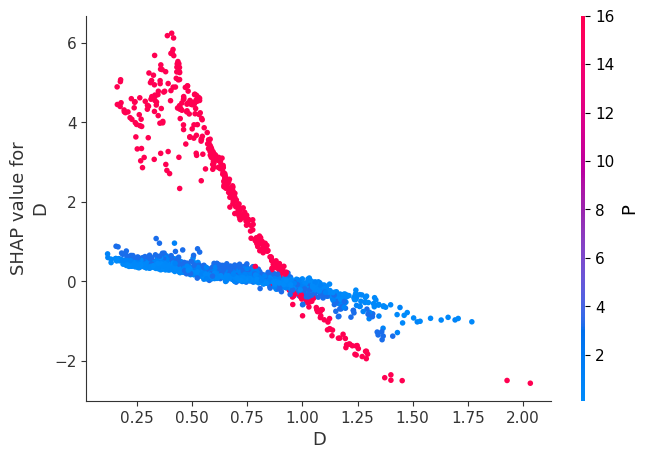

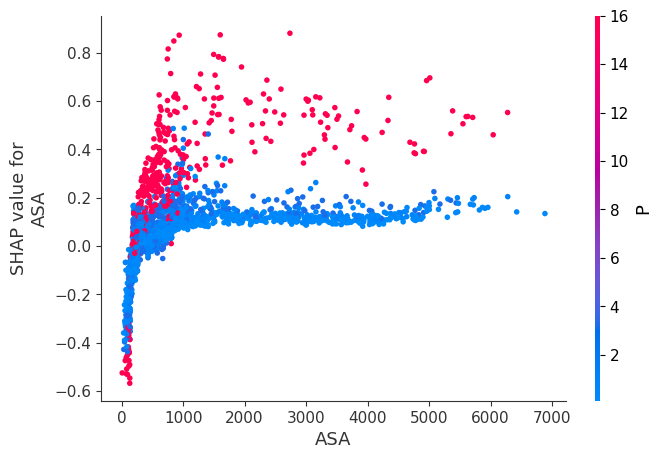

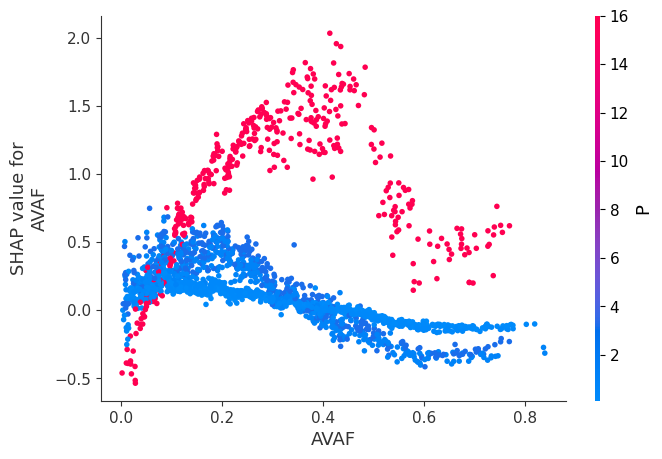

In [ ]:
for feature in feature_names:
    shap.dependence_plot(feature, shap_values_xg, X_train, interaction_index="auto")